# Gaussian Process using Tanimoto kernel

In [1]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rpy2 import robjects
from rpy2.robjects.packages import importr
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

%matplotlib inline
figsize(16, 8)

# Load and adjust data

In [2]:
df_train = pd.read_csv('../data/TableS2_training_pubchem.csv', keep_default_na=False)
df_TS3 = pd.read_csv('../data/TableS3_training_pubchem.csv', keep_default_na=False)

df_train = df_train[df_train['Annotation'] == '']
df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

df_TS3['RRF_Measured'] = df_TS3['RRF_Measured'] * 1e-2
df_TS3['RRF_Predicted'] = df_TS3['RRF_Predicted'] * 1e-2

In [3]:
df_train = df_train[['Name', 'Short Name', 'InChI', 'RRF_Measured', 'RRF_Predicted']]
df_TS3 = df_TS3[['Name', 'Short Name', 'InChI', 'RRF_Measured', 'RRF_Predicted']]

In [4]:
# Create SDF files that will be used for the kernels
for df, file_name in zip([df_train, df_TS3], ['train.sdf', 'test.sdf']):
    df['mol'] = df['InChI'].apply(lambda x: Chem.MolFromInchi(x))

    w = Chem.SDWriter('../data/' + file_name)
    try:
        for mol in df['mol']:
            w.write(mol)
        w.flush()
    finally:
        w.close()

In [5]:
train_sdf_path = os.path.abspath('../data/train.sdf')
test_sdf_path = os.path.abspath('../data/test.sdf')

In [6]:
# Import RChemCpp
rchemcpp = importr("Rchemcpp")

In [7]:
kernelType = 'tanimoto' # other option: minmaxTanimoto
rK = rchemcpp.sd2gramSpectrum(train_sdf_path, kernelType=kernelType)
rKx = rchemcpp.sd2gramSpectrum(train_sdf_path, test_sdf_path, kernelType=kernelType)
rK_ = rchemcpp.sd2gramSpectrum(test_sdf_path, kernelType=kernelType)

[1] "setting morgan labels  0"
[1] "#### initialization Gram OK"
atom type no 1 ; atomic number =  C 
atom type no 2 ; atomic number =  N 
atom type no 3 ; atomic number =  O 
atom type no 4 ; atomic number =  S 
atom type no 5 ; atomic number =  Cl
bond type no 1 ; bond type = 1
bond type no 2 ; bond type = 2
 	 finding paths starting from atoms labeled =  C 
 	 finding paths starting from atoms labeled =  N 
 	 finding paths starting from atoms labeled =  O 
 	 finding paths starting from atoms labeled =  S 
 	 finding paths starting from atoms labeled =  Cl
gramComputeSpectrum (self) OK
[1] "gramComputeSpectrum (self) OK"
[1] "normalize gram (self) OK"
[1] "setting morgan labels  0"
[1] "#### initialization Gram OK"
atom type no 1 ; atomic number =  C 
atom type no 2 ; atomic number =  N 
atom type no 3 ; atomic number =  O 
atom type no 4 ; atomic number =  S 
atom type no 5 ; atomic number =  Cl
bond type no 1 ; bond type = 1
bond type no 2 ; bond type = 2
	 - finding paths starti

In [8]:
K = np.array(rK)
Kx = np.array(rKx)
K_ = np.array(rK_)

# GP

In [9]:
y_train = df_train['RRF_Measured']

In [10]:
s = 0.00005 # noise variance.

L = np.linalg.cholesky(K + s * np.eye(np.size(K, axis=0)))

# compute the mean at our test points.
Lk = np.linalg.solve(L, Kx)
mu = np.dot(Lk.T, np.linalg.solve(L, y_train))

# compute the variance at our test points.
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

In [11]:
df_results = DataFrame({'Predicted': mu, 'Scale': s}, index=df_TS3.index)
df_results = pd.concat([df_TS3[['Name', 'RRF_Measured']], df_results], axis=1)

df_results

,Name,RRF_Measured,Predicted,Scale
0,L-Ornithine,0.00281,0.010614,0.003162
1,N-Methyl-Aspartic acid,0.00842,0.025349,0.234307
2,3-Methyl-L-Histidine,0.01400,0.014001,0.007070
3,L-Theanine,0.02320,0.007672,0.528474
4,L-Citrulline,0.01160,0.021671,0.519554
5,O-Propionyl-L-Carnitine,0.05230,0.055796,0.007070
6,L-Carnosine,0.01910,0.015963,0.465083
7,O-Butyryl-L-Carnitine,0.06660,0.055796,0.007070
8,1-Methyl-Adenosine,0.05240,0.028843,0.397879
9,O-Octoyl-L-Carnitine,0.07780,0.055796,0.007070


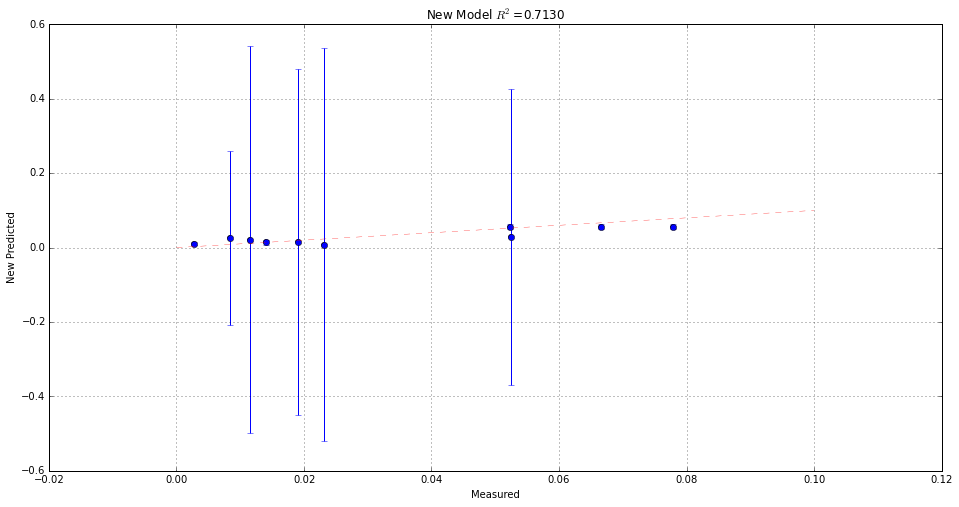

In [12]:
y_true, y_pred_new = df_results['RRF_Measured'], df_results['Predicted']

r2 = r2_score(y_true, y_pred_new)

plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')
plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=s, fmt='o')
plt.plot([0, 0.1], [0, 0.1], 'r--', linewidth=.3)
plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2))

plt.show()

**This model seems overfitted! There are no free parameters to tune.**

# What the model looks like on the training data

In [13]:
kernelType = 'tanimoto'
rK = rchemcpp.sd2gramSpectrum(train_sdf_path, kernelType=kernelType)
rKx = rchemcpp.sd2gramSpectrum(train_sdf_path, train_sdf_path, kernelType=kernelType)
rK_ = rK # rchemcpp.sd2gramSpectrum(train_sdf_path, kernelType=kernelType)

K = np.array(rK)
Kx = np.array(rKx)
K_ = np.array(rK_)

[1] "setting morgan labels  0"
[1] "#### initialization Gram OK"
atom type no 1 ; atomic number =  C 
atom type no 2 ; atomic number =  N 
atom type no 3 ; atomic number =  O 
atom type no 4 ; atomic number =  S 
atom type no 5 ; atomic number =  Cl
bond type no 1 ; bond type = 1
bond type no 2 ; bond type = 2
 	 finding paths starting from atoms labeled =  C 
 	 finding paths starting from atoms labeled =  N 
 	 finding paths starting from atoms labeled =  O 
 	 finding paths starting from atoms labeled =  S 
 	 finding paths starting from atoms labeled =  Cl
gramComputeSpectrum (self) OK
[1] "gramComputeSpectrum (self) OK"
[1] "normalize gram (self) OK"
[1] "setting morgan labels  0"
[1] "#### initialization Gram OK"
atom type no 1 ; atomic number =  C 
atom type no 2 ; atomic number =  N 
atom type no 3 ; atomic number =  O 
atom type no 4 ; atomic number =  S 
atom type no 5 ; atomic number =  Cl
bond type no 1 ; bond type = 1
bond type no 2 ; bond type = 2
	 - finding paths starti

In [14]:
s = 0.00005 # noise variance.

L = np.linalg.cholesky(K + s * np.eye(np.size(K, axis=0)))

# compute the mean at our test points.
Lk = np.linalg.solve(L, Kx)
mu = np.dot(Lk.T, np.linalg.solve(L, df_train['RRF_Measured']))

# compute the variance at our test points.
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

In [15]:
df_results2 = DataFrame({'Predicted': mu, 'Scale': s}, index=df_train.index)
df_results2 = pd.concat([df_train[['Name', 'RRF_Measured']], df_results2], axis=1)

df_results2.head()

,Name,RRF_Measured,Predicted,Scale
3,Histamine,0.00111,0.001111,0.007071
5,L-Valine,0.00188,0.010614,0.003162
7,Nicotinamide,0.00322,0.003222,0.007071
8,Nicotinic acid,0.00250,0.002499,0.007070
9,L-Leucine,0.01610,0.010614,0.003162


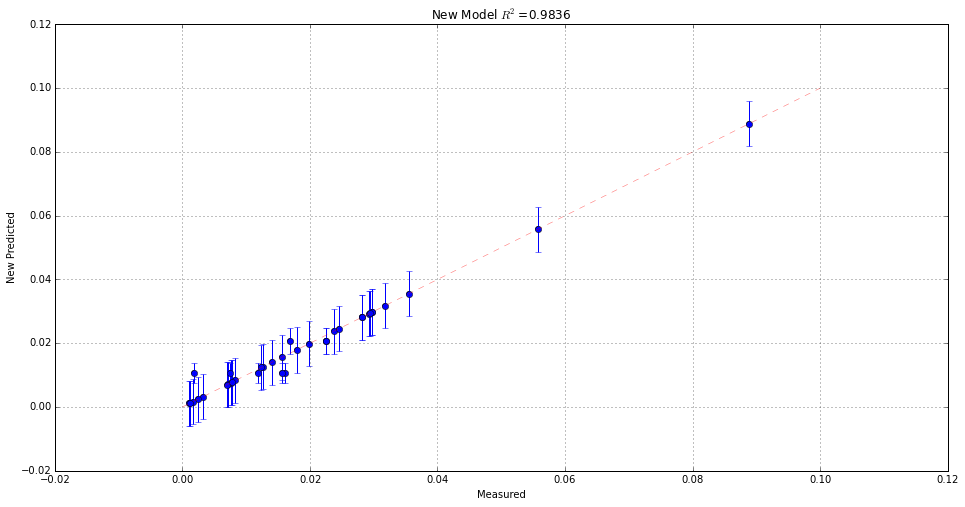

In [16]:
y_true, y_pred_new = df_results2['RRF_Measured'], df_results2['Predicted']

r2 = r2_score(y_true, y_pred_new)

plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')
plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=s, fmt='o')
plt.plot([0, 0.1], [0, 0.1], 'r--', linewidth=.3)
plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2))

plt.show()